# Wells Fargo Challenge

- https://www.mindsumo.com/contests/campus-analytics-challenge-2021

### To Complete a Submission:

Build a classification model for predicting elder fraud in the digital payments space as described in Rule 4, which:

- Handles missing variables
- Maximizes the F1 score
- Uses the given data set
- Includes suitable encoding schemes
- Has the least set of feature variables

### Resources
- https://github.com/pdglenn/WellsFargoAnalyticsChallenge

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns

# following few lines are to supress the pandas warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

pd.options.mode.chained_assignment = None 
pd.options.display.max_columns = 20
np.set_printoptions(suppress=True) 

data_dir = "../dataset/"
image_dir = "../images/"


## Loading the data

In [2]:
# load the file
df_orig = pd.read_excel(data_dir+"trainset.xlsx", engine='openpyxl')
df_orig.head(2)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,...,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,ACTN_CD,ACTN_INTNL_TXT,TRAN_TYPE_CD,ACTVY_DT,FRAUD_NONFRAUD
0,5.38,23619.91,47,4,2777,1/16/2018 11:3:58,cox communications inc.,southwest,nevada,MOBL,...,NV,2/24/2021 15:55:10,1993-01-06,5/3/2021 18:3:58,5/3/2021,SCHPMT,P2P_COMMIT,P2P,5/3/2021,Non-Fraud
1,65.19,0.00,45,5,2721,NaN,charter communications,southwest,california,MOBL,...,CA,NaN,1971-01-07,1/13/2021 19:19:37,1/13/2021,SCHPMT,P2P_COMMIT,P2P,1/13/2021,Non-Fraud


## Train test split

Before doing any data visualization let's set some test data aside and use them to score the model later on.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# stratify the target column so that the distribution look similar in the train and test data
df_train0, df_test0 = train_test_split(df_orig,
                               test_size = .2,
                               random_state = 8848,
                               shuffle = True,
                               stratify = df_orig["FRAUD_NONFRAUD"])

## Feature Engineering, Transformation and Data Imputation

- Generate New features from the given date and time features

In [4]:
def convert_date_format(x):
    if len(str(x).split("/"))>1:
        m,d,y=str(x).strip().split()[0].split("/")
        if d=='0':
            d='1'
        elif d=='31':
            d='30'
        return "-".join([y,m,d])
    else:
        return str(x).split()[0]

def feature_engineering(df):
    # conver the _DT columns to pandas datetime
    cols_DT = [c for c in df.columns if "_DT" in c]
    df[cols_DT] = df[cols_DT].apply(pd.to_datetime)
    # convert the TRAN_Timestamp to only hour
    df["TRAN_HOUR"]=pd.to_datetime(df['TRAN_TS']).dt.strftime("%H")
    # Fill the Nulls for Phone update by the cust_since_date and keep only date
    df["PH_NUM_UPDT_DT"]=pd.to_datetime(df["PH_NUM_UPDT_TS"].fillna(df["CUST_SINCE_DT"]).apply(convert_date_format))
    # Fill the Nulls for pwd update by the cust_since_date and keep only date
    df["PWD_UPDT_DT"]=pd.to_datetime(df["PWD_UPDT_TS"].fillna(df["CUST_SINCE_DT"]).apply(convert_date_format))
    # Num of days between TRAN_DATE and PWD_UPDATE_DAYS
    df["PWD_UPDT_DAYS"] = (df["TRAN_DT"]-df["PWD_UPDT_DT"]).dt.days
    
    # Num of days between TRAN_DATE and PHONE_NUM_UPDATE_DAYS
    df["PH_NUM_UPDT_DAYS"] = (df["TRAN_DT"]-df["PH_NUM_UPDT_DT"]).dt.days
    
    # Num of days between TRAN_DATE and CUST_SINCE_DATE
    df["TRAN_DAYS"] = (df["TRAN_DT"] - df["CUST_SINCE_DT"]).dt.days
    # Num of days between PWD update and phone number update
    df["PH_NUM_PWD_DAYS"]=df["PH_NUM_UPDT_DAYS"] - df["PWD_UPDT_DAYS"]
    return df

In [5]:
def get_imputation_values(df):
    
    # find numerical and categorical columns
    nume_cols = list(df.select_dtypes(include="number").columns)
    cate_cols = list(df.select_dtypes(exclude="number").columns)
    nume_cols.remove('CUST_ZIP')
    cate_cols.append('CUST_ZIP')
    nume_cols.remove('FRAUD_NONFRAUD')
   
    impute_vals={}

    for col in df.columns:
        if col in nume_cols:
            impute_vals[col] = df[col].median()
        elif col in cate_cols:
            impute_vals[col] = df[col].mode()[0]
    return nume_cols, cate_cols, impute_vals

In [6]:
def impute_data(df, impute_dict):
    """
    this function takes in a dataframe and list of columns which have missing values
    then imputes those columns using the precomputed values.
    """
    for col in list(impute_dict.keys()):
        df[col] = df[col].fillna(impute_dict[col])
    return df

In [7]:
def transform_cate_data(df):
    #CUST_STATE
    # keep only CO, TX, MN, AZ and convert rest into OTHER
    df["CUST_STATE"] = df["CUST_STATE"].apply(lambda x: x if x in ["CO", "TX", "MN", "AZ"] else "OTHER")
    #OPEN_ACCT_CT
    #keep only the [2,9] and convert others to 10
    df["OPEN_ACCT_CT"] = df["OPEN_ACCT_CT"].apply(lambda x: x if x in range(1,13) else 13)
    return df

## Modelling

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve

In [9]:
class Model_training:
    def __init__(self, model, X_train, y_train, X_test, y_test, savename="Fig"):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test  = X_test
        self.y_test  = y_test
        self.savename = savename
        self.model.fit(self.X_train, self.y_train)
        
    def print_metrics(self):
        round_to_pct = lambda x: np.round(100*x, 2)
        y_pred = self.model.predict(self.X_test)
        ac = round_to_pct(accuracy_score(self.y_test, y_pred))
        f1 = round_to_pct(f1_score(self.y_test, y_pred))
        pr = round_to_pct(precision_score(self.y_test, y_pred))
        re = round_to_pct(recall_score(self.y_test, y_pred))
        print (f"Accuracy = {ac}% F1 Score= {f1}% \nPrecision={pr}% Recall= {re}%")
        print (classification_report(self.y_test, y_pred))
        return (self.model, (ac, f1, pr, re))
        
    def displot(self):
        pr=self.model.predict_proba(self.X_test)        
        roc_auc = np.round(roc_auc_score(self.y_test,
                                         self.model.predict_proba(self.X_test)[:, 1]), 2)

        pr_df = pd.DataFrame({'pred_0':pr[:,0], 
                              'pred_1':pr[:,1], 
                              'y': self.y_test})

        ax=sns.displot(data=pr_df, 
                       x='pred_1', 
                       hue='y', 
                       alpha=0.8, 
                       kind="kde",
                       height = 3.5, 
                       aspect=1.8);
        
        plt.xlabel("Prob. Positive Predictions", fontsize=16)
        plt.text(0.2, 2, "ROC_AUC="+str(roc_auc), fontsize=16)
        plt.ylabel("Density", fontsize=16)
        
        plt.yticks(fontsize=16);
        plt.xticks(fontsize=16);
        figname = image_dir+"nb5_displot_"+self.savename+"_nb3.png"
        plt.savefig(figname, dpi=300, bbox_inches='tight')

    def feature_importance(self):

        try:
            mod = self.model.base_estimator
            #mod.feature_importances_
        except:
            mod = self.model.best_estimator_
            
        df_imp = pd.DataFrame({"Feature":self.X_train.columns, 
                               "Feature Importance":mod.feature_importances_})

        #df_imp = pd.DataFrame({"Feature":self.X_train.columns, 
        #                       "Feature Importance":self.model.feature_importances_})
        
        df_imp = df_imp.sort_values(by=['Feature Importance'],
                                    axis=0,
                                    ascending=True)
        
        df_imp.plot(kind='barh',
                    x='Feature', 
                    y='Feature Importance',
                    color="C2", figsize=(8,5));
        
        plt.grid(axis='x')
        plt.yticks(fontsize=16);
        plt.ylabel('');
        plt.xticks(fontsize=16);
        plt.legend(loc='best',fontsize=16);
        
        figname = image_dir+"nb5_feat_imp_"+self.savename+"_nb3.png"
        plt.savefig(figname, dpi=300, bbox_inches='tight')
        
    def plot_roc_curve(self):
        roc_auc = np.round(roc_auc_score(self.y_test,
                                         self.model.predict_proba(self.X_test)[:, 1]), 2)
        label_name = self.savename +"\nAUC = "+str(roc_auc)
        
        plot_roc_curve(self.model, self.X_test, self.y_test,
                       lw=3., color='C2', label=label_name)
        plt.title("ROC Curve", fontsize=18)
        plt.xlabel("False Positive Rate", fontsize=16)
        plt.ylabel("True Positive Rate", fontsize=16)
        plt.xticks(fontsize=16);
        plt.yticks(fontsize=16);
        plt.legend(loc="center", fontsize=14);
        plt.axvline(x=0, color='k', ls='--', lw=1)
        plt.axhline(y=0, color='k', ls='--', lw=1)
        plt.axhline(y=1, color='k', ls='--', lw=1)
        
        figname = image_dir+"nb5_roc_curve_"+self.savename+"_nb3.png"
        plt.savefig(figname, dpi=300, bbox_inches='tight')

## Modeling 3: Numerical [given + engineered] + Categorical features

In [10]:
import category_encoders as ce

In [11]:
df2 = df_train0.copy()
df2["FRAUD_NONFRAUD"] =  df2["FRAUD_NONFRAUD"].map({"Fraud":1, "Non-Fraud":0})
df2 = feature_engineering(df2)
nume_cols, cate_cols, impute_vals = get_imputation_values(df2)
df2 = impute_data(df2, impute_vals)
df2 = transform_cate_data(df2)

In [12]:
cate_cols_to_keep = ['ALERT_TRGR_CD', "CUST_STATE"]

In [13]:
encoder = ce.OneHotEncoder()
df2_tr_cat = encoder.fit_transform(df2[cate_cols_to_keep])
df2_tr_join = pd.concat( [df2[nume_cols], df2_tr_cat], axis=1)
X_train2 = df2_tr_join
y_train2 = df2["FRAUD_NONFRAUD"]

In [14]:
df2_te = df_test0.copy()
df2_te["FRAUD_NONFRAUD"] =  df2_te["FRAUD_NONFRAUD"].map({"Fraud":1, "Non-Fraud":0})
df2_te = feature_engineering(df2_te)
df2_te = impute_data(df2_te, impute_dict=impute_vals)
df2_te = transform_cate_data(df2_te)

In [15]:
df2_te_cat = encoder.transform(df2_te[cate_cols_to_keep])
df2_te_join = pd.concat( [df2_te[nume_cols], df2_te_cat], axis=1)
X_test2 = df2_te_join
y_test2 = df2_te["FRAUD_NONFRAUD"]

In [16]:
X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape

((11200, 16), (11200,), (2800, 16), (2800,))

In [17]:
"FRAUD_NONFRAUD" in list(X_test2.columns)

False

In [18]:
X_train2.head(2)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_DAYS,PH_NUM_UPDT_DAYS,TRAN_DAYS,PH_NUM_PWD_DAYS,ALERT_TRGR_CD_1,ALERT_TRGR_CD_2,CUST_STATE_1,CUST_STATE_2,CUST_STATE_3,CUST_STATE_4,CUST_STATE_5
2413,487.93,3714.91,43,5,1037,12146,347,12146,-11799,1,0,1,0,0,0,0
1003,4.84,0.00,53,5,305,1478,12443,12443,10965,1,0,0,1,0,0,0


Accuracy = 94.5% F1 Score= 90.48% 
Precision=93.25% Recall= 87.88%
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1967
           1       0.93      0.88      0.90       833

    accuracy                           0.94      2800
   macro avg       0.94      0.93      0.93      2800
weighted avg       0.94      0.94      0.94      2800

Best parameters: {'learning_rate': 0.1, 'max_depth': 8}


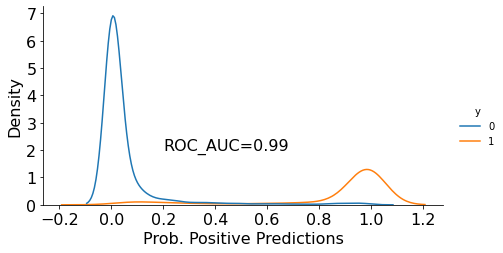

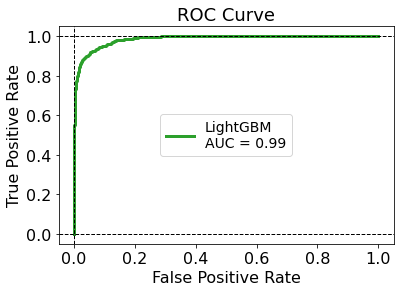

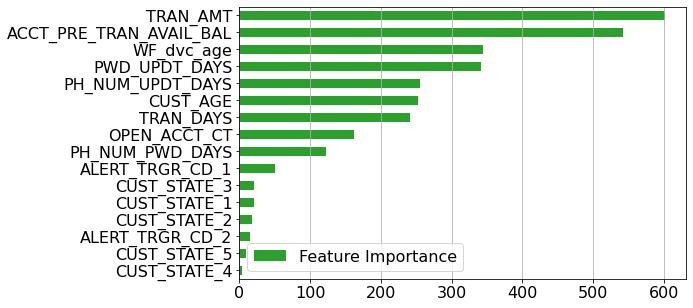

In [20]:
lgb_gs = GridSearchCV(LGBMClassifier(),
                      param_grid={'max_depth':[8, 9, 10, 11, 12, 13, 14],
                                  'learning_rate':[0.1, 0.5]},
                      scoring = 'f1',
                      verbose = 0)

mod = Model_training(lgb_gs, X_train2, y_train2, X_test2, y_test2, "LightGBM")
mod_tr, _= mod.print_metrics()
print ("Best parameters:", mod_tr.best_params_)
mod.displot()
mod.plot_roc_curve()
mod.feature_importance()

Accuracy = 94.5% F1 Score= 90.48% 
Precision=93.25% Recall= 87.88%
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1967
           1       0.93      0.88      0.90       833

    accuracy                           0.94      2800
   macro avg       0.94      0.93      0.93      2800
weighted avg       0.94      0.94      0.94      2800



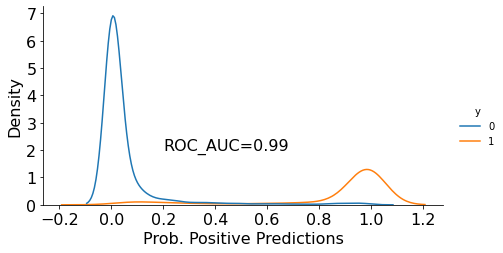

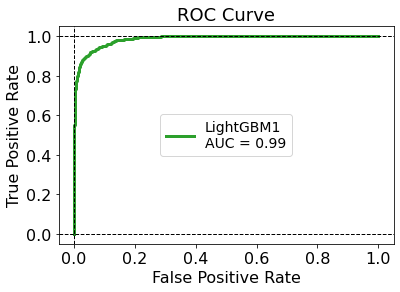

In [23]:
lgb = LGBMClassifier(learning_rate= 0.1, max_depth= 8)
mod = Model_training(lgb, X_train2, y_train2, X_test2, y_test2, "LightGBM1")
mod_tr, _= mod.print_metrics()
mod.displot()
mod.plot_roc_curve()

## Prepare the test set

In [26]:
# load the file
df_test_orig = pd.read_excel(data_dir+"testset.xlsx", engine='openpyxl')
df_test_orig.head(2)

,dataset_id,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,...,CUST_ZIP,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,ACTN_CD,ACTN_INTNL_TXT,TRAN_TYPE_CD,ACTVY_DT
0,1,54.25,0.0,23,4,634,9/18/2020 9:33:44,charter communications inc,southwest,california,...,55414,MN,7/8/2018 9:45:37,2011-02-19,1/8/2021 11:33:44,1/8/2021,SCHPMT,P2P_COMMIT,P2P,1/8/2021
1,2,110.30,0.0,56,3,1876,5/16/2021 17:2:31,comcast,mountain,colorado,...,77095,TX,NaN,2001-11-20,2/27/2021 7:2:31,2/27/2021,SCHPMT,P2P_COMMIT,P2P,2/27/2021


In [27]:
df_test = feature_engineering(df_test_orig)

In [28]:
df_test.head(2)

,dataset_id,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,...,ACTN_INTNL_TXT,TRAN_TYPE_CD,ACTVY_DT,TRAN_HOUR,PH_NUM_UPDT_DT,PWD_UPDT_DT,PWD_UPDT_DAYS,PH_NUM_UPDT_DAYS,TRAN_DAYS,PH_NUM_PWD_DAYS
0,1,54.25,0.0,23,4,634,9/18/2020 9:33:44,charter communications inc,southwest,california,...,P2P_COMMIT,P2P,2021-01-08,11,2018-07-08,2020-09-18,112,915,3611,803
1,2,110.30,0.0,56,3,1876,5/16/2021 17:2:31,comcast,mountain,colorado,...,P2P_COMMIT,P2P,2021-02-27,07,2001-11-20,2021-05-16,-78,7039,7039,7117


In [29]:
df_test = impute_data(df_test, impute_vals)


In [30]:
df_test = transform_cate_data(df_test)

In [31]:
df_test_cat = encoder.transform(df_test[cate_cols_to_keep])
df_test_join = pd.concat( [df_test[nume_cols], df_test_cat], axis=1)
X_test = df_test_join

In [32]:
print ( X_test.shape )
X_test.head(2)

(6000, 16)


,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_DAYS,PH_NUM_UPDT_DAYS,TRAN_DAYS,PH_NUM_PWD_DAYS,ALERT_TRGR_CD_1,ALERT_TRGR_CD_2,CUST_STATE_1,CUST_STATE_2,CUST_STATE_3,CUST_STATE_4,CUST_STATE_5
0,54.25,0.0,23,4,634,112,915,3611,803,1,0,0,0,1,0,0
1,110.30,0.0,56,3,1876,-78,7039,7039,7117,0,1,0,1,0,0,0


In [36]:
df_test_orig["dataset_id"]

(6000,)

In [40]:
preds = mod_tr.predict(X_test)
preds

array([0, 0, 0, ..., 0, 1, 0])

In [42]:
preds_reversed = (preds+1)%2

In [43]:
# check
(preds+preds_reversed).sum()

6000

# NOTE

The challenge note asks us to present the submission file with a mapping of `0 (FRAUD) and 1 (NonFraud)`. In the entire work I used the notation the other  way around.  `1 (FRAUD) and 0 (NonFraud)`.

### So in the submission reverse the prediction values.


In [44]:
df_submit = pd.DataFrame({"dataset_id":df_test_orig["dataset_id"].values, 
                          "FRAUD_NONFRAUD":preds_reversed})

df_submit["FRAUD_NONFRAUD"] =  df_submit["FRAUD_NONFRAUD"].map({0:"Fraud", 1:"Non-Fraud"})

In [46]:
df_submit.head(2)

,dataset_id,FRAUD_NONFRAUD
0,1,Non-Fraud
1,2,Non-Fraud


In [47]:
df_submit.to_csv("submission.csv")

## Versions of the packages used

In [61]:
import matplotlib
import sklearn, 
matplotlib.__version__, sklearn.__version__
import xgboost, catboost, lightgbm


In [69]:
from platform import python_version

python_version()


'3.9.5'

In [70]:
packs = [["pandas", pd], 
         ["numpy", np],
         ["matplotlib", matplotlib],
         ["seaborn", sns],
         ["sklearn", sklearn],
         ["xgboost", xgboost], 
         ["catboost", catboost], 
         ["lightgbm", lightgbm],
         ["category_encoders", ce]
        ]        

for p_name, p in packs:
    print ("Package:", p_name,"  \tVersion:", p.__version__ )


Package: pandas   	Version: 1.2.4
Package: numpy   	Version: 1.19.5
Package: matplotlib   	Version: 3.4.2
Package: seaborn   	Version: 0.11.1
Package: sklearn   	Version: 0.23.2
Package: xgboost   	Version: 1.4.2
Package: catboost   	Version: 1.0.0
Package: lightgbm   	Version: 3.2.1
Package: category_encoders   	Version: 2.2.2


In [71]:
for p_name, p in packs:
    print (p_name,":", p.__version__ )


pandas : 1.2.4
numpy : 1.19.5
matplotlib : 3.4.2
seaborn : 0.11.1
sklearn : 0.23.2
xgboost : 1.4.2
catboost : 1.0.0
lightgbm : 3.2.1
category_encoders : 2.2.2
